# Implement MLGCN on BlogCatalog dataset

* **Link to the paper:** https://arxiv.org/pdf/1912.11757.pdf 

In [1]:
import pandas as pd 
import numpy as np
import networkx as nx
import scipy.sparse as sp
from sklearn import preprocessing
import matplotlib.pyplot as plt
import csv
import torch
import itertools 

### Custom made functions: 
`normalize` : used in the normalization step for the adjacency matrix

`threshold` : used for defining the sigmoid output to 0 or 1

`accuracy_sample_class` : accuracy for samples having multilabels

`micor_F1` and `macro_F1` : built based on the equations provided in the paper

In [2]:
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [3]:
def threshold(output):
    output[output > 0.5] = 1
    output[output <= 0.5] = 0
    return output

In [4]:
def accuracy_sample_class(output, labels):
    """ 
    output is of shape (N,C)
    Labels is of shape (N,C)
    Result : acc gives the accuracy computed according to the sample-class view
    """
    N = labels.shape[0]
    C = labels.shape[1]
    corr = np.sum(np.equal(output, labels))
    # corr is the number of equal elements between labels and output and thus the number of correctly classified 
    # labels for each sample 
    acc = corr/(N*C)
    return acc

In [5]:
def micro_F1(output, labels):
    TP = np.array([])
    FN = np.array([])
    FP = np.array([])
    N = labels.shape[0]
    L = labels.shape[1]
    for l in range(L):
        tp = 0
        fn = 0
        fp = 0
        ol = output[:,l]
        ll = labels[:,l]
        for i in range(N):
            if ll[i] == 1 and ol[i] == 1:
                tp +=1
            if ol[i] == 0 and ll[i] == 1:
                fn +=1
            if ol[i] == 1 and ll[i] == 0:
                fp +=1
        TP = np.append(TP, tp)
        FN = np.append(FN, fn)
        FP = np.append(FP, fp)
    return np.sum(2*TP)/np.sum(2*TP + FN + FP)

In [7]:
def macro_F1(output, labels):
    TP = np.array([])
    FN = np.array([])
    FP = np.array([])
    N = labels.shape[0]
    L = labels.shape[1]
    for l in range(L):
        tp = 0
        fn = 0
        fp = 0
        ol = output[:,l]
        ll = labels[:,l]
        for i in range(N):
            if ll[i] == 1 and ol[i] == 1:
                tp +=1
            if ol[i] == 0 and ll[i] == 1:
                fn +=1
            if ol[i] == 1 and ll[i] == 0:
                fp +=1
        TP = np.append(TP, tp)
        FN = np.append(FN, fn)
        FP = np.append(FP, fp)
    return np.sum(2*TP/(2*TP + FN + FP))

### Load Function:
Creating the input feature matrices, adjacency matrices and embeddings as input to the model from the two given csv files in `BlogCatalog` folder.

In [8]:
# number of labels
m = 39

In [23]:
def load_data(data_name):
    edges_file = data_name + "/edges.csv"
    node_label_file = data_name + "/group-edges.csv"
    label_occ_file = data_name + "/label_co-occurences.csv"
    nnlg_file = data_name + "/edges_node_node_label.csv"
    llng_file = data_name + "/edges_label_label_node.csv"
    label_raw, nodes = [], []
    with open(node_label_file) as file_to_read: 
        while True:
            lines = file_to_read.readline()
            if not lines:
                break 
            node, label = lines.split(",")
            label_raw.append(int(label))
            nodes.append(int(node))
    label_raw = np.array(label_raw)
    nodes = np.array(nodes)
    unique_nodes = np.unique(nodes)
    labels = np.zeros((unique_nodes.shape[0], m))
    for l in range(1, m+1, 1):
        indices = np.argwhere(label_raw == l).reshape(-1)
        n_l = nodes[indices]
        for n in n_l:
            labels[n-1][l-1] = 1
    
    # node-node-label graph 
    label_nodes = label_raw + unique_nodes.shape[0] 
    n_n_l_nodes = np.concatenate((unique_nodes, np.unique(label_nodes)))
    df = pd.DataFrame(list())
    df.to_csv(nnlg_file)
    f = open(nnlg_file, "r+")
    file_to_read = open(edges_file, "r")
    f.writelines(file_to_read.readlines())
    a = np.dstack((nodes, label_nodes)).reshape(label_nodes.shape[0],2)
    e = ["\n"] + [",".join(item)+"\n" for item in a.astype(str)]
    f.writelines(e)
    f.close()
    
    nnlg_file = "BlogCatalog/edges_node_node_label.csv"
    nnl_graph = nx.read_edgelist(nnlg_file, delimiter = ",", nodetype = int)
    E = nx.adjacency_matrix(nnl_graph, nodelist = n_n_l_nodes)
    main_graph = open(edges_file, "rb")
    G = nx.read_edgelist(main_graph, delimiter = ",", nodetype = int)
    A = nx.adjacency_matrix(G, nodelist = unique_nodes)
    A = sp.coo_matrix(A.todense())
    # the input node feature is identity matrix now
    X = np.eye(A.shape[0])
    X_embedding = X[:,:400]
    # Normalize the adjancency matrix with the added self loops
    A_tilde = normalize(A + 3*sp.eye(A.shape[0]))
    
    # Label-label-node graph 
    edges = []
    list_edges = []
    for k in range(labels.shape[0]):
        indices = np.argwhere(labels[k] == 1).reshape(-1)
        if indices.shape[0]>1:
            for subset in itertools.combinations(indices, 2): 
                if (list(subset) not in list_edges) or ([subset[1], subset[0]] not in list_edges):
                    list_edges.append([subset[0], subset[1]+labels.shape[0]])# check if the common nodes should be before or after the label nodes
                    edges.append(str(subset[0]+1) + "," + str(subset[1] +1) + "\n")
    df = pd.DataFrame(list())
    df.to_csv(label_occ_file)
    label_file = open(label_occ_file, "r+")
    label_file.writelines(edges)
    label_file.close()
    unique_label_ID = np.arange(1,40)
    label_file = open(label_occ_file, "rb")
    label_graph = nx.read_edgelist(label_file, delimiter = ",", nodetype = int)
    C = nx.adjacency_matrix(label_graph, nodelist = unique_label_ID)
    label_file.close()
    # Normalize the co-occurence matrix with the added self loops
    C_tilde = normalize(C + 2*sp.eye(C.shape[0]))
    Y = np.random.rand(m,X.shape[0]) #instead of X[:m]
    Y_embedding = Y[:,:400]
    labels_ind = label_raw 
    nodes_ind = nodes + labels.shape[1]
    a_1 = np.dstack((labels_ind,nodes)).reshape(labels_ind.shape[0],2)
    e_1 = [",".join(item)+"\n" for item in a_1.astype(str)]
    file = open(label_occ_file, "r+")
    file.writelines(e_1)
    file.close()
    f_1 = open(label_occ_file, "rb")
    l_l_n_nodes = np.concatenate((np.unique(nodes_ind),np.unique(labels_ind)))
    lln_graph = nx.read_edgelist(f_1, delimiter = ",", nodetype = int)
    F = nx.adjacency_matrix(lln_graph, nodelist = l_l_n_nodes)
    F = sp.coo_matrix(F.todense())
    f_1.close()
    # Normalize the adjancency matrix with the added self loops
    E = normalize(E + 3*sp.eye(E.shape[0]))
    E_tilde = E[:len(unique_nodes)]
    # Normalize the adjancency matrix with the added self loops
    F = normalize(F + 2*sp.eye(F.shape[0]))
    F_tilde = F[len(unique_nodes):]
    
    indices = np.arange(A.shape[0]).astype('int32') # should be shuffled
    np.random.shuffle(indices)
    
    idx_train = indices[:(4 * A.shape[0]) // 5]
    idx_val = indices[(4 * A.shape[0]) // 5 : (9 * A.shape[0]) // 10]
    idx_test = indices[(9 * A.shape[0]) // 10:]
    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)
    C_tilde = torch.FloatTensor(np.array(C_tilde.todense()))
    E_tilde = torch.FloatTensor(np.array(E_tilde.todense()))
    F_tilde = torch.FloatTensor(np.array(F_tilde.todense()))
    A_tilde = torch.FloatTensor(np.array(A_tilde.todense()))
    labels = torch.FloatTensor(labels)
    Y = torch.FloatTensor(Y)
    X = torch.FloatTensor(X)
    X_embedding = torch.FloatTensor(X_embedding)
    Y_embedding = torch.FloatTensor(Y_embedding)
    
    return G, X, Y, X_embedding, Y_embedding, F_tilde, E_tilde, C_tilde,A_tilde, idx_train, idx_val,idx_test, labels

In [24]:
G, X, Y, X_embedding, Y_embedding, F_tilde, E_tilde, C_tilde,A_tilde, idx_train, idx_val,idx_test, labels = load_data("BlogCatalog")

In [11]:
# Define some variables 
n = A_tilde.shape[0]
m = C_tilde.shape[0]

### Let's get down to the training 

The cell below contains the models importing from `models1.py`, if the **Jupyter Notebook IDE** is used,

change `from models1 import High_Layer, Low_Layer, GCN` 

to `from MLMI_MLGCN_project.models1 import High_Layer, Low_Layer, GCN`

In [12]:
from __future__ import division
from __future__ import print_function

from models1 import High_Layer, Low_Layer, GCN


import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

In [13]:
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=300,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.0001,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=0,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=400,
                    help='Number of hidden units.')                   
parser.add_argument('--hidden_ll', type=int, default=400,
                    help='Number of hidden units.')
parser.add_argument('--hidden_hl', type=int, default=400,
                    help='Number of hidden units.')
parser.add_argument('--hidden1', type=int, default=1000,
                    help='Number of hidden units.')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('-f')

args = parser.parse_args([])
args.cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [59]:
# Define the models (high layer and low layer) and the optimizers for each on of them
low_layer = Low_Layer(nfeat = A_tilde.shape[0],
                      nhid_lowlayer = args.hidden_ll,
                      nhid_highlayer = args.hidden_hl,
                      nclass = C_tilde.shape[0],
                      dropout = args.dropout)
optimizer_lowlayer = optim.Adam(low_layer.parameters(),lr = args.lr, weight_decay = args.weight_decay)
        
high_layer = High_Layer(nfeat = A_tilde.shape[0],
                        nhid_lowlayer = args.hidden_ll,
                        nhid_highlayer = args.hidden_hl,
                        nclass = C_tilde.shape[0],
                        dropout = args.dropout)
optimizer_highlayer = optim.Adam(high_layer.parameters(),lr = args.lr, weight_decay = args.weight_decay)

In [46]:
truth = torch.LongTensor(np.arange(m))

### Two Separate Training Parts

Define the trainig part for low_layer as train_low and high_layer as train_high, this will make the iterating between two layers easier.

In [56]:
loss_train_list = []
micro_F1_train_list = []
loss_val_list = []
micro_F1_val_list = []

In [57]:
def train_low(epoch):
      global loss_train_list 
      global micro_F1_train_list 
      global loss_val_list
      global micro_F1_val_list
      low_layer.train()
      optimizer_lowlayer.zero_grad()
      output_ll, X_embedding_ = low_layer(Y_, X, E_tilde, A_tilde)
    
      X_embedding_ = X_embedding_.detach()
    
      loss_train_ll = np.sum([F.binary_cross_entropy_with_logits(output_ll[idx_train][:,i], labels[idx_train][:,i]) for i in range(m)])
      micro_F1_train = micro_F1(threshold(output_ll.detach().numpy()[idx_train]), labels.detach().numpy()[idx_train])
      loss_train_ll.backward()
      optimizer_lowlayer.step()
    
      # validation part
      low_layer.eval()
      output_ll, X_embedding_val = low_layer(Y_, X, E_tilde, A_tilde)
      loss_val = np.sum([F.binary_cross_entropy_with_logits(output_ll[idx_val][:,i], labels[idx_val][:,i]) for i in range(m)])
      micro_F1_val = micro_F1(threshold(output_ll.detach().numpy()[idx_val]), labels.detach().numpy()[idx_val])

      loss_train_list.append(loss_train_ll.item())
      loss_val_list.append(loss_val.item())
      micro_F1_train_list.append(micro_F1_train.item())
      micro_F1_val_list.append(micro_F1_val.item())

      print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train_ll.item()),
          'micro_F1_train: {:.4f}'.format(micro_F1_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'micro_F1_val: {:.4f}'.format(micro_F1_val.item())
          )

      return X_embedding_

In [58]:
def train_high(epoch):
    high_layer.train()
    optimizer_highlayer.zero_grad()
    output_hl, Y_embedding_ = high_layer(X_, Y, F_tilde, C_tilde)
    Y_embedding_ = Y_embedding_.detach()
    loss_train_hl = F.nll_loss(output_hl, truth)
    loss_train_hl.backward()
    optimizer_highlayer.step()

    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train_hl.item()),
          #'acc_train: {:.4f}'.format(acc_train.item()),
          )
    
    return Y_embedding_


### Training 

This part is for training the two layers GCN, which contains two parts:

`train_embedding` : we first train the meaningful embedding to give it as the input to high_layer, # training epochs = 50.

`train_sep` : training high_layer and low_layer one by one, start with high_layer, each layer will be train for 50 epochs as suggested in the literature.

In [42]:
simple_GCN = GCN(nfeat = X.shape[1],
                      nhid = args.hidden,
                      nclass = m,
                      dropout = args.dropout)
optimizer_emb = optim.Adam(simple_GCN.parameters(),lr = args.lr, weight_decay = args.weight_decay)

In [43]:
def train_embedding(epoch):
    simple_GCN.train()
    optimizer_emb.zero_grad()
    output, X_embedding = simple_GCN(X, A_tilde)
    loss_train = np.sum([F.binary_cross_entropy_with_logits(output[idx_train][:,i], labels[idx_train][:,i]) for i in range(39)])
    micro_F1_train = micro_F1(threshold(output.detach().numpy()[idx_train]), labels.detach().numpy()[idx_train])
    # macro_F1_train = macro_F1(threshold(output.detach().numpy()[idx_train]), labels.detach().numpy()[idx_train])
    loss_train.backward()
    optimizer_emb.step()

    if not args.fastmode:
        simple_GCN.eval()
        output, X_embedding_val = simple_GCN(X, A_tilde)

    loss_val = np.sum([F.binary_cross_entropy_with_logits(output[idx_val][:,i], labels[idx_val][:,i]) for i in range(39)])
    micro_F1_val = micro_F1(threshold(output.detach().numpy()[idx_val]), labels.detach().numpy()[idx_val])
    # macro_F1_val = macro_F1(threshold(output.detach().numpy()[idx_val]), labels.detach().numpy()[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'micro_F1_train: {:.4f}'.format(micro_F1_train.item()),
        #   'macro_F1_train: {:.4f}'.format(macro_F1_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'micro_F1_val: {:.4f}'.format(micro_F1_val.item())
        #   'macro_F1_val: {:.4f}'.format(macro_F1_val.item())
          )
    return X_embedding

In [44]:
for epoch in range(50):
    X_embedding = train_embedding(epoch)

X_embedding = X_embedding.detach()

Epoch: 0001 loss_train: 37.3034 micro_F1_train: 0.0757 loss_val: 37.3005 micro_F1_val: 0.0743
Epoch: 0002 loss_train: 37.2986 micro_F1_train: 0.0763 loss_val: 37.2948 micro_F1_val: 0.0740
Epoch: 0003 loss_train: 37.2928 micro_F1_train: 0.0754 loss_val: 37.2892 micro_F1_val: 0.0740
Epoch: 0004 loss_train: 37.2877 micro_F1_train: 0.0749 loss_val: 37.2835 micro_F1_val: 0.0741
Epoch: 0005 loss_train: 37.2795 micro_F1_train: 0.0755 loss_val: 37.2778 micro_F1_val: 0.0742
Epoch: 0006 loss_train: 37.2776 micro_F1_train: 0.0755 loss_val: 37.2721 micro_F1_val: 0.0742
Epoch: 0007 loss_train: 37.2691 micro_F1_train: 0.0745 loss_val: 37.2665 micro_F1_val: 0.0742
Epoch: 0008 loss_train: 37.2643 micro_F1_train: 0.0751 loss_val: 37.2608 micro_F1_val: 0.0743
Epoch: 0009 loss_train: 37.2568 micro_F1_train: 0.0745 loss_val: 37.2551 micro_F1_val: 0.0743
Epoch: 0010 loss_train: 37.2528 micro_F1_train: 0.0750 loss_val: 37.2494 micro_F1_val: 0.0742
Epoch: 0011 loss_train: 37.2482 micro_F1_train: 0.0752 loss_

In [60]:
X_ = X_embedding.clone()
Y_ = Y_embedding.clone()

In [55]:
X_embedding

tensor([[0.0383, 0.0000, 0.0000,  ..., 0.0151, 0.0391, 0.0190],
        [0.0367, 0.0000, 0.0000,  ..., 0.0184, 0.0450, 0.0022],
        [0.0411, 0.0000, 0.0000,  ..., 0.0182, 0.0443, 0.0198],
        ...,
        [0.0346, 0.0000, 0.0000,  ..., 0.0195, 0.0323, 0.0202],
        [0.0218, 0.0000, 0.0000,  ..., 0.0147, 0.0351, 0.0072],
        [0.0144, 0.0000, 0.0000,  ..., 0.0103, 0.0436, 0.0131]])

In [61]:
# function to train them separately
def train_sep(epoch, M, N):
    global Y_
    global X_

    if np.floor(epoch/M) % 2 == 0:
        Y_ = train_high(epoch)
        
    if np.floor(epoch/M) % 2 == 1:
        X_ = train_low(epoch)

In [62]:
t_total = time.time()
for epoch in range(200):
    train_sep(epoch, 50, 50)

Epoch: 0001 loss_train: 3.6762
Epoch: 0002 loss_train: 3.6641
Epoch: 0003 loss_train: 3.6641
Epoch: 0004 loss_train: 3.6655
Epoch: 0005 loss_train: 3.6738
Epoch: 0006 loss_train: 3.6663
Epoch: 0007 loss_train: 3.6650
Epoch: 0008 loss_train: 3.6662
Epoch: 0009 loss_train: 3.6583
Epoch: 0010 loss_train: 3.6598
Epoch: 0011 loss_train: 3.6616
Epoch: 0012 loss_train: 3.6619
Epoch: 0013 loss_train: 3.6628
Epoch: 0014 loss_train: 3.6617
Epoch: 0015 loss_train: 3.6639
Epoch: 0016 loss_train: 3.6619
Epoch: 0017 loss_train: 3.6659
Epoch: 0018 loss_train: 3.6697
Epoch: 0019 loss_train: 3.6663
Epoch: 0020 loss_train: 3.6597
Epoch: 0021 loss_train: 3.6556
Epoch: 0022 loss_train: 3.6603
Epoch: 0023 loss_train: 3.6615
Epoch: 0024 loss_train: 3.6623
Epoch: 0025 loss_train: 3.6591
Epoch: 0026 loss_train: 3.6619
Epoch: 0027 loss_train: 3.6562
Epoch: 0028 loss_train: 3.6661
Epoch: 0029 loss_train: 3.6585
Epoch: 0030 loss_train: 3.6646
Epoch: 0031 loss_train: 3.6611
Epoch: 0032 loss_train: 3.6678
Epoch: 0

Text(0, 0.5, 'a.u.')

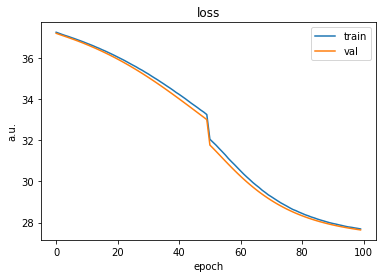

In [67]:
plt.plot(loss_train_list,label='train')
plt.plot(loss_val_list,label='val')
plt.legend(loc='upper right')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('a.u.')

Text(0, 0.5, 'value')

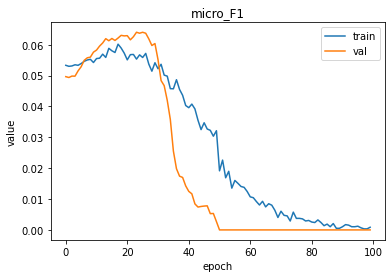

In [68]:
plt.plot(micro_F1_train_list,label='train')
plt.plot(micro_F1_val_list,label='val')
plt.legend(loc='upper right')
plt.title('micro_F1')
plt.xlabel('epoch')
plt.ylabel('value')

In [69]:
def test():
    low_layer.eval()
    output_ll, X_embedding_ = low_layer(Y_, X, E_tilde, A_tilde)
    loss_test = np.sum([F.binary_cross_entropy_with_logits(output_ll[idx_test][:,i], labels[idx_test][:,i]) for i in range(39)])
    micro_F1_train = micro_F1(threshold(output_ll.detach().numpy()[idx_test]), labels.detach().numpy()[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "micro_F1= {:.4f}".format(micro_F1_train.item()))
    return threshold(output_ll.detach().numpy()[idx_test])

In [70]:
y_predict = test()

Test set results: loss= 27.6970 micro_F1= 0.0000


In [78]:
y_predict = y_predict.astype(int)

In [79]:
np.sum(y_predict)

0

In [72]:
from sklearn.metrics import classification_report

In [77]:
y_true = labels.numpy()[idx_test]
target_names = ['class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9',
                'class 10', 'class 11', 'class 12', 'class 13', 'class 14', 'class 15', 'class 16', 'class 17', 'class 18', 'class 19',
                'class 20', 'class 21', 'class 22', 'class 23', 'class 24', 'class 25', 'class 26', 'class 27', 'class 28', 'class 29',
                'class 30', 'class 31', 'class 32', 'class 33', 'class 34', 'class 35', 'class 36', 'class 37', 'class 38', 'class 39']
print(classification_report(y_true, y_predict, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.00      0.00      0.00        25
     class 2       0.00      0.00      0.00        76
     class 3       0.00      0.00      0.00        59
     class 4       0.00      0.00      0.00        28
     class 5       0.00      0.00      0.00        85
     class 6       0.00      0.00      0.00        80
     class 7       0.00      0.00      0.00        52
     class 8       0.00      0.00      0.00       169
     class 9       0.00      0.00      0.00        28
    class 10       0.00      0.00      0.00        46
    class 11       0.00      0.00      0.00        52
    class 12       0.00      0.00      0.00         4
    class 13       0.00      0.00      0.00        50
    class 14       0.00      0.00      0.00        34
    class 15       0.00      0.00      0.00        12
    class 16       0.00      0.00      0.00        29
    class 17       0.00      0.00      0.00        48
    class 18       0.00    

/Users/linheshan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/linheshan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/linheshan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
